# Module 4 Assignment

In this assignment, you'll use some of the key concepts from the module to create a neural network for image classification of items of clothing. Step one will be to normalize the input images, and you'll use NDArray operations to calculate the channel mean. You'll create a function to evaluate the performance of networks on the data, and construct a couple of different neural networks for image classification.

## 0) Setup

We start with a number of required imports and set the data paths.

In [1]:
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.data.vision import FashionMNIST
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm

In [2]:
M4_DATA = Path(os.getenv('DATA_DIR', '../../data'), 'module_4')
M4_IMAGES = Path(M4_DATA, 'images')
M4_MODELS = Path(M4_DATA, 'models')

## 1) Data (& NDArray Operations)

We'll use the in-built dataset called `FashionMNIST` which is a variant of the commonly used `MNIST` dataset. It consists of 60,000 training images and 10,000 test images, and each image is a 28px by 28px greyscale image. We'll start by creating the `dataset` and visualize an example image.

In [3]:
test_dataset = FashionMNIST(train=False, root=M4_IMAGES).transform_first(transforms.ToTensor())

(28, 28)


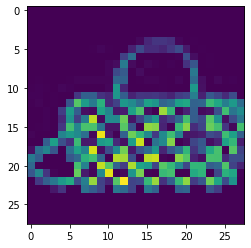

In [4]:
sample_idx = 126
sample_data, sample_label = test_dataset[sample_idx]
print(sample_data[0].shape)
plt.imshow(sample_data[0].asnumpy())  # 0 for first and only channel (since greyscale).

One important step before passing images to the network is normalization: i.e. shifting and scaling the pixel values so that they are zero-centered on average and have unit variance.

One method of normalization is pixelwise, where each **pixel** should have a unit normal distribution of values. Another is channelwise, where each **channel** should have a unit normal distribution of values. 

One of the first steps in the pixelwise approach is to calculate an 'average image' from the dataset. Using a sample of 1024 images, you should now implement a function to calculate the average intensity for every pixel. You'd typically want to calculate this from all samples of the dataset, but 1024 samples will be sufficient for now.

In [5]:
test_dataloader = mx.gluon.data.DataLoader(test_dataset, shuffle=False, batch_size=1024)
for data, label in test_dataloader:
    break
print(data.shape)

(1024, 1, 28, 28)


In [6]:
def get_average_image_from_batch(batch):
    """
    Given a batch of images, this function should calculate the 'average image'.
    
    :param batch: batch of images in NCHW layout.
    :type batch: mx.nd.NDArray
    
    :return: average image in CHW layout.
    :rtype: mx.nd.NDArray
    """
    # YOUR CODE HERE
    #print(batch.shape)
    #sum all elements in each channel and divide by the number of elements
    batch_mean = mx.ndarray.sum(batch,axis=0)/(batch.shape[0])
    #print(batch_mean.shape)
    return batch_mean
    raise NotImplementedError()

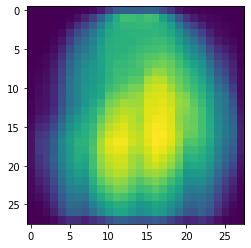

In [7]:
average_image = get_average_image_from_batch(data)
assert average_image.shape == (1, 28, 28)
plt.imshow(average_image[0].asnumpy())  # 0 for first and only channel (since greyscale).

Using the average image that was calculated above, you should now implement a function to perform the pixelwise normalization.

In [8]:
def subtract_average_image(sample, average_image):
    """
    Given a sample images, this function should return a pixelwise normalized image,
    using a pre-calculated average image.
    
    :param sample: sample image in CHW layout.
    :type sample: mx.nd.NDArray
    :param average_image: average image of the dataset in CHW layout.
    :type average_image: mx.nd.NDArray
    
    :return: pixelwise normalized image in CHW layout.
    :rtype: mx.nd.NDArray
    """
    # YOUR CODE HERE
    sub = sample -average_image
    return sub
    raise NotImplementedError()

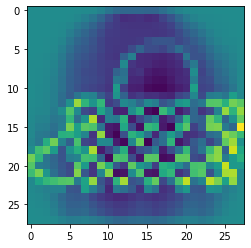

In [9]:
normalized_sample_data = subtract_average_image(sample_data, average_image)
assert normalized_sample_data.shape == (1, 28, 28)
np.testing.assert_array_almost_equal(normalized_sample_data.asnumpy(), (sample_data - average_image).asnumpy())
plt.imshow(normalized_sample_data[0].asnumpy())  # 0 for first and only channel (since greyscale).

You've now created a transform for pixelwise normalization! As mentioned previously, another common method for normalization is channelwise normalization. Complete the following function to calculate the channel averages from a batch of multi-channel inputs.

Note: although the image from our dataset only have one channel, your function should support cases where there are more than one channel (e.g. RGB images).

**Hint**: Check out the `axis` (or `dim`) arguments on MXNet NDArray functions.

In [10]:
def get_channel_average_from_batch(batch):
    """
    Given a batch of images, this function should return the
    average value for each channel across the images of the batch.
    
    :param batch: batch of images in NCHW layout.
    :type batch: mx.nd.NDArray
    
    :return: channel averages in C layout.
    :rtype: mx.nd.NDArray
    """
    # YOUR CODE HERE
    #print(batch.shape)
    channel_avg = mx.ndarray.mean(batch,axis=(0,2,3))
    #print(channel_avg.shape)
    return channel_avg
    raise NotImplementedError()

In [11]:
channel_average = get_channel_average_from_batch(data).asscalar()
print(channel_average)
assert isinstance(channel_average, np.float32)
np.testing.assert_almost_equal(channel_average, 0.28757906, decimal=5)

test_averages = mx.nd.array([1,2,3,4])
test_input = mx.nd.reshape(test_averages, shape=(1,4,1,1)) * mx.nd.ones(shape=(10,4,25,25))
test_channel_average = get_channel_average_from_batch(test_input)
np.testing.assert_array_almost_equal(test_averages.asnumpy(), test_channel_average.asnumpy())

0.28757906


Using this channel average, we can use the `Normalize` transform to apply this to all samples in our dataset as they are loaded.

In [12]:
channel_std = 0.31
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_average, channel_std)
])

In [13]:
train_dataset = FashionMNIST(train=True, root=M4_IMAGES).transform_first(transform)
test_dataset = FashionMNIST(train=False, root=M4_IMAGES).transform_first(transform)
train_dataloader = mx.gluon.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = mx.gluon.data.DataLoader(train_dataset, shuffle=False, batch_size=128)

## 2) Metrics

In this section, you'll implement a function to test the prediction quality of networks. Using `Accuracy` as the evaluation metric, complete the following function that takes a network and a dataloader (with test data) and returns an MXNet Metric that has been updated with labels and predictions. We'll use this function in the next section, when we train classification networks.

**Hint**: You'll find classes in the `mxnet.metric` subpackage useful for this task.

In [14]:
def calculate_accuracy(network, dataloader):
    """
    Calculates accuracy of the network on the data given by the dataloader.
    
    :param network: network to be tested
    :type network: mx.gluon.Block
    :param dataloader: dataloader for test data
    :type dataloader: mx.gluon.data.DataLoader
    
    :return: updated metric
    :rtype: mx.metric.EvalMetric
    """
    # YOUR CODE HERE
    accuracy=mx.metric.Accuracy()
    #raise NotImplementedError()
    for data, labels in tqdm(dataloader):
        preds = network(data)
        # YOUR CODE HERE
        accuracy.update(labels,preds)
        #raise NotImplementedError()
    return accuracy

In [15]:
test_network = mx.gluon.nn.Dense(units=10)
test_network.initialize()
metric = calculate_accuracy(test_network, test_dataloader)
print(metric.get())
isinstance(metric, mx.metric.EvalMetric)
assert metric.name == 'accuracy'
assert metric.num_inst == 60000

100%|██████████| 469/469 [01:25<00:00,  5.85it/s]

('accuracy', 0.08005)


## 3) Network

In the section, you'll implement a couple of different image classification networks and train then on the `FashionMNIST` dataset. A `train` function is already provided in this assignment, because the focus will be on network construction.

In [16]:
def train(network, dataloader):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(network.collect_params(), 'sgd', {'learning_rate': 0.1})
    for data, label in tqdm(dataloader):
        with mx.autograd.record():
            output = network(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

Your first model should be a sequential network, with 3 layers. You first layer should have 16 hidden units, the second should have 8 hidden units and the last layer should the correct number of output units for the classification task at hand. You should add ReLU activations on all hidden layers, but not the output layer. You should define `network` in the cell below.

**Hint**: You'll find classes in the `mxnet.gluon.nn` subpackage useful for this task.

In [18]:
# YOUR CODE HERE
from mxnet.gluon import nn
network=nn.Sequential()
network.add(nn.Dense(16,activation='relu'))
network.add(nn.Dense(8,activation='relu'))
network.add(nn.Dense(10))
#raise NotImplementedError()

In [19]:
assert isinstance(network, mx.gluon.nn.Sequential)
assert len(network) == 3
assert isinstance(network[0], mx.gluon.nn.Dense)
assert network[0].act.name.endswith('relu')
assert network[0].weight.shape[0] == 16
assert isinstance(network[1], mx.gluon.nn.Dense)
assert network[1].act.name.endswith('relu')
assert network[1].weight.shape[0] == 8
assert isinstance(network[2], mx.gluon.nn.Dense)
assert network[2].act is None
assert network[2].weight.shape[0] == 10

With your network now defined, you should initialize its parameters using the Xavier method in the cell below.

**Hint**: You'll find classes in the `mxnet.init` subpackage useful for this task.

In [21]:
# YOUR CODE HERE
from mxnet import initializer
initializer=mx.initializer.Xavier(rnd_type='uniform',factor_type='avg',magnitude=1)
#raise NotImplementedError()
network.initialize(initializer)

In [22]:
assert isinstance(initializer, mx.initializer.Xavier)

We'll now check the network summary and see that the network has 12786 trainable parameters.

In [23]:
network.summary(data)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (1024, 1, 28, 28)               0
        Activation-1                    <Symbol dense4_relu_fwd>               0
        Activation-2                                  (1024, 16)               0
             Dense-3                                  (1024, 16)           12560
        Activation-4                    <Symbol dense5_relu_fwd>               0
        Activation-5                                   (1024, 8)               0
             Dense-6                                   (1024, 8)             136
             Dense-7                                  (1024, 10)              90
Parameters in forward computation graph, duplicate included
   Total params: 12786
   Trainable params: 12786
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique 

And use the `calculate_accuracy` function defined in the previous section to evaluate the performance of this architecture.

In [24]:
train(network, train_dataloader)
metric = calculate_accuracy(network, test_dataloader)
print(metric.get())

100%|██████████| 469/469 [01:22<00:00,  5.69it/s]

('accuracy', 0.8211666666666667)


You're final objective in this assignment is to try a different architecture that uses convolutional and max pooling layers. You should define another sequential network, but this time it should have 5 layers in total:

1. Convolutional Layer (32 channels, 3x3 kernel and ReLU activation)
2. Max Pooling Layer (2x2 kernel and 2x2 stride)
3. Convolutional Layer (16 channels, 3x3 kernel and ReLU activation)
4. Max Pooling Layer (2x2 kernel and 2x2 stride)
5. Dense Layer (10 output units)

In [25]:
# YOUR CODE HERE
network=nn.Sequential()
network.add(nn.Conv2D(32,(3,3),activation='relu'))
network.add(nn.MaxPool2D(pool_size=(2,2),strides=(2,2)))
network.add(nn.Conv2D(16,(3,3),activation='relu'))
network.add(nn.MaxPool2D(pool_size=(2,2),strides=(2,2)))
network.add(nn.Dense(10))
#raise NotImplementedError()

In [26]:
assert isinstance(network, mx.gluon.nn.Sequential)
assert len(network) == 5
assert isinstance(network[0], mx.gluon.nn.Conv2D)
assert network[0].act.name.endswith('relu')
assert network[0].weight.shape[0] == 32
assert isinstance(network[1], mx.gluon.nn.MaxPool2D)
assert isinstance(network[2], mx.gluon.nn.Conv2D)
assert network[2].act.name.endswith('relu')
assert network[2].weight.shape[0] == 16
assert isinstance(network[3], mx.gluon.nn.MaxPool2D)
assert isinstance(network[4], mx.gluon.nn.Dense)
assert network[4].act is None
assert network[4].weight.shape[0] == 10

Let's initialize the parameters of the network, and show a summary of the network architecture.

With 8954 trainable parameters, this network's got 30% fewer parameters than the previous network.

In [27]:
network.initialize(init=initializer)
network.summary(data)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (1024, 1, 28, 28)               0
        Activation-1                     <Symbol conv0_relu_fwd>               0
        Activation-2                          (1024, 32, 26, 26)               0
            Conv2D-3                          (1024, 32, 26, 26)             320
         MaxPool2D-4                          (1024, 32, 13, 13)               0
        Activation-5                     <Symbol conv1_relu_fwd>               0
        Activation-6                          (1024, 16, 11, 11)               0
            Conv2D-7                          (1024, 16, 11, 11)            4624
         MaxPool2D-8                            (1024, 16, 5, 5)               0
             Dense-9                                  (1024, 10)            4010
Parameters in forward comput

And finally, let's evaluate the network performance.

In [28]:
train(network, train_dataloader)
metric = calculate_accuracy(network, test_dataloader)
print(metric.get())

100%|██████████| 469/469 [04:47<00:00,  3.40it/s]  

('accuracy', 0.8252333333333334)


We're only training for a single epoch here. You'd expect to get improved accuracy if training for more epochs. 